In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 224, 224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 3 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

InceptionV3_model = InceptionV3(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

InceptionV3_model.trainable=True

In [21]:
#for layer in InceptionV3_model.layers[:-50]:
#    layer.trainable = False

In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in InceptionV3_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001717540B408>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000017175453B48>,conv2d,True
2,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001717F5D27C8>,batch_normalization,True
3,<tensorflow.python.keras.layers.core.Activation object at 0x000001717FD10888>,activation,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000017106477E88>,conv2d_1,True
...,...,...,...
306,<tensorflow.python.keras.layers.core.Activation object at 0x00000173E6CF7A88>,activation_85,True
307,<tensorflow.python.keras.layers.merge.Concatenate object at 0x00000173E6E033C8>,mixed9_1,True
308,<tensorflow.python.keras.layers.merge.Concatenate object at 0x00000173E6F72348>,concatenate_1,True
309,<tensorflow.python.keras.layers.core.Activation object at 0x00000173E6FCD908>,activation_93,True


In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization

#from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix# build model architecture 
model = Sequential()
model.add(InceptionV3_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())
print("Las métricas del modelo son: ",model.metrics_names)

ValueError: Unknown metric function:f1score

In [8]:
import time
inicio=time.time()
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=100,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)
fin=time.time()
print(inicio-fin)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 33s 334ms/step - loss: 1.1002 - accuracy: 0.3531 - val_loss: 1.1042 - val_accuracy: 0.3250
Epoch 2/100
100/100 [==============================] - 23s 234ms/step - loss: 1.0945 - accuracy: 0.3630 - val_loss: 1.0958 - val_accuracy: 0.3587
Epoch 3/100
100/100 [==============================] - 21s 213ms/step - loss: 1.0908 - accuracy: 0.3690 - val_loss: 1.0891 - val_accuracy: 0.3794
Epoch 4/100
100/100 [==============================] - 21s 211ms/step - loss: 1.0851 - accuracy: 0.3903 - val_loss: 1.0863 - val_accuracy: 0.4006
Epoch 5/100
100/100 [==============================] - 21s 212ms/step - loss: 1.0768 - accuracy: 0.4125 - val_loss: 1.0765 - val_accuracy: 0.4281
Epoch 6/100
100/100 [==============================] - 22s 218ms/step - loss: 1.0734 - accuracy: 0.42

100/100 [==============================] - 22s 217ms/step - loss: 0.6550 - accuracy: 0.9068 - val_loss: 0.6888 - val_accuracy: 0.8581
Epoch 54/100
100/100 [==============================] - 22s 217ms/step - loss: 0.6623 - accuracy: 0.8991 - val_loss: 0.6856 - val_accuracy: 0.8625
Epoch 55/100
100/100 [==============================] - 22s 219ms/step - loss: 0.6656 - accuracy: 0.8969 - val_loss: 0.6898 - val_accuracy: 0.8556
Epoch 56/100
100/100 [==============================] - 22s 219ms/step - loss: 0.6515 - accuracy: 0.9062 - val_loss: 0.6826 - val_accuracy: 0.8675
Epoch 57/100
100/100 [==============================] - 22s 218ms/step - loss: 0.6500 - accuracy: 0.9122 - val_loss: 0.6832 - val_accuracy: 0.8662
Epoch 58/100
100/100 [==============================] - 22s 219ms/step - loss: 0.6537 - accuracy: 0.9056 - val_loss: 0.6860 - val_accuracy: 0.8612
Epoch 59/100
100/100 [==============================] - 22s 219ms/step - loss: 0.6541 - accuracy: 0.9059 - val_loss: 0.6833 - val_a

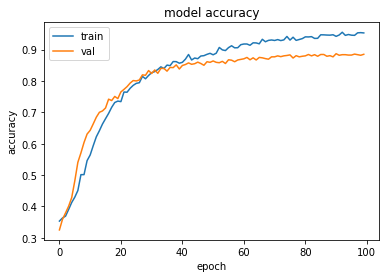

-0.5447838306427002


In [9]:
# summarize history for accuracy
import time
inicio=time.time()
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fin=time.time()
print(inicio-fin)

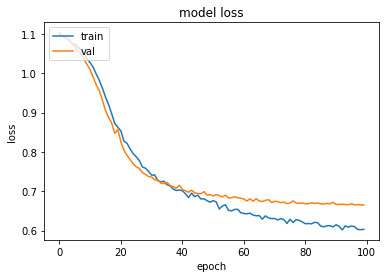

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
213/213 [==============================] - 12s 58ms/step - loss: 0.6404 - accuracy: 0.9110
El modelo predice el  91.10194444656372 % de los datos


In [1]:
from keras.models import model_from_json
# serializar el modelo a JSON
model_json = model.to_json()
with open("ModeloInceptionV3_91-1.json", "w") as json_file:
    json_file.write(model_json)
# serializar los pesos a HDF5
model.save_weights("PesosInceptionV3_91-1.h5")
print("Modelo Guardado!")

Using TensorFlow backend.


NameError: name 'model' is not defined